Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imagecodecs_lite-2020.1.31-py3-none-any.whl (1.4 kB)
  Using cached imagecodecs-2021.11.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model 23-06-22-1.h5 not found. Creating a new one
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 400, 400, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 32)     0         
 )                            

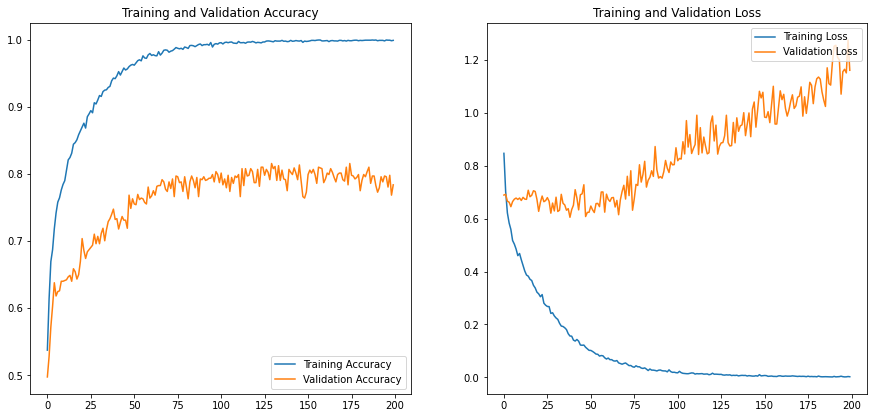

In [1]:
from keras.layers.normalization.batch_normalization import BatchNormalization
!pip install imagecodecs-lite
!pip install imagecodecs
!pip uninstall tiffile
import imagecodecs
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
import csv
from random import shuffle

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf


def load_data(path):
    info = []
    images_list = []
    images_class = []
    print('Loading ', path, 'in memory...')
    with open(path, newline='') as csv_file:
        images_reader = csv.reader(csv_file)
        next(images_reader)
        for row in images_reader:
            info.append(row)
    shuffle(info)

    for elem in info:
        images_list.append(imread('/content/drive/MyDrive/Colab Notebooks/Train&Validation/' + elem[0])[55:455, 55:455].reshape(400, 400, 1))
        images_class.append(elem[1] == 'covid')
    return np.array(images_list), np.array(images_class)


def create_model():
    model = Sequential()
    model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(400, 400, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Conv2D(128, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.25))
    

    model.add(Conv2D(256, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(128, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Conv2D(32, 3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))

    return model


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


Adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
def run_model2(path, epochs_number, folder): #Save acc, loss,... in a file to allow interruption
    try:
        my_model = load_model('/content/drive/MyDrive/Colab Notebooks/' + path)
        print('\033[94m'+'\033[1m' + 'Model Loaded' + '\033[0m')
        my_model.summary()
    except OSError:
        print('\033[91m'+'\033[1m'+'Model', path, 'not found. Creating a new one'+'\033[0m')
        my_model = create_model()
        my_model.summary()
        my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size'),
                         optimizer=Adam, metrics=["accuracy"])

    train_images, train_classes = load_data('/content/drive/MyDrive/Colab Notebooks/CSV/train' + str(folder) + '.csv')
    validation_images, validation_classes = load_data('/content/drive/MyDrive/Colab Notebooks/CSV/validation' + str(folder) + '.csv')
    datagen.fit(train_images)
    history = my_model.fit(train_images, train_classes, epochs=epochs_number, validation_data=(validation_images,
                                                                                               validation_classes))
    my_model.save('/content/drive/MyDrive/Colab Notebooks/' + path)
    return history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'], epochs_number


def plot_accuracy(accuracy, validation_accuracy, loss, validation_loss, epochs): #Add save as png
    epochs_range = range(epochs)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


accuracy, validation_accuracy, loss, validation_loss, epochs = run_model2('23-06-22-1.h5', 200, 1)

plot_accuracy(accuracy, validation_accuracy, loss, validation_loss, epochs)